In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import copy

In [2]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
batch_size = 64
num_epochs = 30
early_stop_patience = 3
data_dir = '../data/MNIST'

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307],
                         std=[0.3081])
])

train_dataset = MNIST(root= data_dir, train=True, download=True, transform=transform)
test_dataset = MNIST(root= data_dir, train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleMLP()
model.to(device)

def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

# for param in model.parameters():
#     param.requires_grad = True

SimpleMLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses, test_losses, train_accs, test_accs = [], [], [], []
best_loss = float('inf')
patience = 0
best_epoch = 0
best_model = None

for epoch in range(num_epochs):
    model.train()
    total, correct, train_loss = 0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    acc = correct / total
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(acc)

    model.eval()
    total, correct, val_loss = 0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            val_loss += criterion(out, y).item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    val_acc = correct / total
    test_losses.append(val_loss / len(test_loader))
    test_accs.append(val_acc)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Train Acc: {acc:.4f} | Test Acc: {val_acc:.4f}")

    if test_losses[-1] < best_loss:
        best_loss = test_losses[-1]
        best_model = copy.deepcopy(model.state_dict())
        best_epoch = epoch + 1
        patience = 0
    else:
        patience += 1
        if patience >= early_stop_patience:
            print(f"\n🛑 Early stopping triggered at epoch {epoch+1}. Best model was from epoch {best_epoch}.")
            break


Epoch 01 | Train Loss: 0.4213 | Test Loss: 0.2012 | Train Acc: 0.8792 | Test Acc: 0.9424
Epoch 02 | Train Loss: 0.1729 | Test Loss: 0.1438 | Train Acc: 0.9506 | Test Acc: 0.9563
Epoch 02 | Train Loss: 0.1729 | Test Loss: 0.1438 | Train Acc: 0.9506 | Test Acc: 0.9563
Epoch 03 | Train Loss: 0.1258 | Test Loss: 0.1201 | Train Acc: 0.9640 | Test Acc: 0.9648
Epoch 03 | Train Loss: 0.1258 | Test Loss: 0.1201 | Train Acc: 0.9640 | Test Acc: 0.9648
Epoch 04 | Train Loss: 0.0985 | Test Loss: 0.1030 | Train Acc: 0.9722 | Test Acc: 0.9679
Epoch 04 | Train Loss: 0.0985 | Test Loss: 0.1030 | Train Acc: 0.9722 | Test Acc: 0.9679
Epoch 05 | Train Loss: 0.0800 | Test Loss: 0.0907 | Train Acc: 0.9774 | Test Acc: 0.9722
Epoch 05 | Train Loss: 0.0800 | Test Loss: 0.0907 | Train Acc: 0.9774 | Test Acc: 0.9722
Epoch 06 | Train Loss: 0.0662 | Test Loss: 0.0852 | Train Acc: 0.9809 | Test Acc: 0.9744
Epoch 06 | Train Loss: 0.0662 | Test Loss: 0.0852 | Train Acc: 0.9809 | Test Acc: 0.9744
Epoch 07 | Train Loss

In [7]:
if best_model is not None:
    model.load_state_dict(best_model)

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        correct += (model(x).argmax(1) == y).sum().item()
        total += y.size(0)

print(f"\n✅ Final MNIST Test Accuracy: {correct / total:.4f}")


✅ Final MNIST Test Accuracy: 0.9792


In [8]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        outputs = model(x)
        preds = outputs.argmax(1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(y.numpy())

print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes if hasattr(test_dataset, 'classes') else [str(i) for i in range(10)]))



📊 Classification Report:
              precision    recall  f1-score   support

    0 - zero       0.98      0.99      0.98       980
     1 - one       0.99      0.99      0.99      1135
     2 - two       0.98      0.98      0.98      1032
   3 - three       0.97      0.98      0.97      1010
    4 - four       0.98      0.98      0.98       982
    5 - five       0.98      0.98      0.98       892
     6 - six       0.99      0.98      0.98       958
   7 - seven       0.98      0.97      0.98      1028
   8 - eight       0.98      0.97      0.98       974
    9 - nine       0.96      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



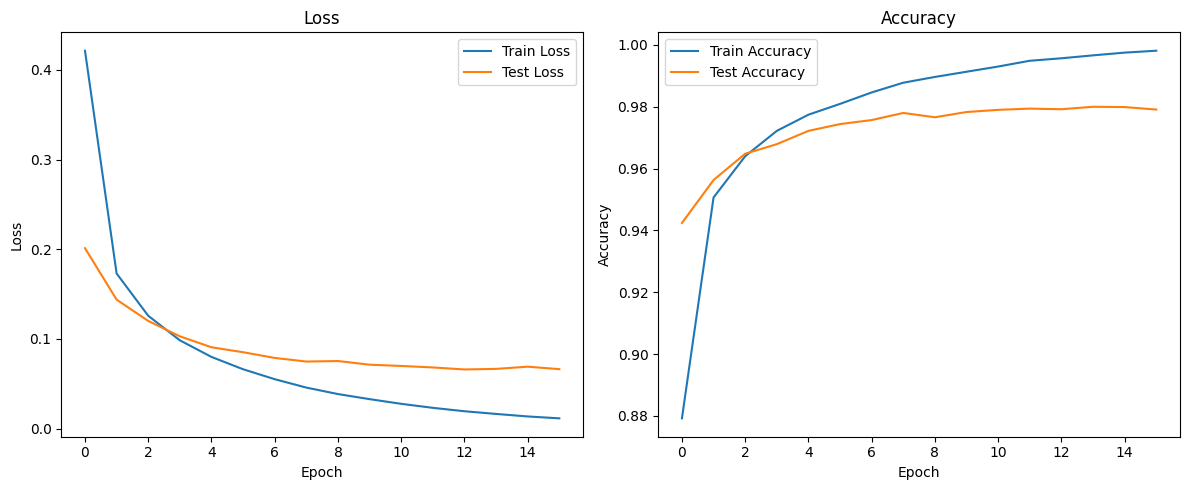

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
print(train_losses)
print(test_losses)
print(train_accs)
print(test_accs)

[0.4212801659952349, 0.172949534229267, 0.1258475279389843, 0.09848279837391842, 0.07997752317010975, 0.06623861707472947, 0.05516310169923502, 0.04579340091108212, 0.038589441271842335, 0.03292307453795966, 0.02769840401133149, 0.023240946686398714, 0.019443800529665642, 0.016440182687530516, 0.013640061563398661, 0.011533978248279649]
[0.2012035584041647, 0.14382891620918634, 0.120085918532898, 0.10295255336121531, 0.09073797009802263, 0.08523873145881875, 0.07886210658493345, 0.07484012262752594, 0.07540393388492002, 0.07133027379791057, 0.06990935874044017, 0.06826261248885192, 0.06601017427912122, 0.06665042349253966, 0.06910896245981522, 0.06636297813939987]
[0.8792, 0.95065, 0.964, 0.9722, 0.9774333333333334, 0.9809333333333333, 0.9846333333333334, 0.9877833333333333, 0.98965, 0.9913333333333333, 0.9930166666666667, 0.9948833333333333, 0.9956833333333334, 0.9966333333333334, 0.9975166666666667, 0.9981333333333333]
[0.9424, 0.9563, 0.9648, 0.9679, 0.9722, 0.9744, 0.9757, 0.978, 0